# ScRNA-Seq of human bone marrow cells from Oetjen et al.

Inspired by the work of [Luecken, MD. et al.](https://www.nature.com/articles/s41592-021-01336-8#Sec35)
<br>Code: https://github.com/theislab/scib-reproducibility/tree/main 
<br>
<br>Data from [Oetjen, KA. et al.](https://insight.jci.org/articles/view/124928)
<br>Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3396161 

In [8]:
# Import packages
import scanpy as sc
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix, issparse
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from functions import data_preprocessing as dp
import seaborn as sb
import random
import warnings
import logging
import json

In [9]:
# Path of data
file_base = '../../../../../data/raw/immune_cells/bone_marrow_human/GSM3396161_A/'
count_file_end = 'GSM3396161_matrix_A.mtx.gz'
gene_data_end = 'GSM3396161_genes_A.tsv.gz'
barcode_data_end = 'GSM3396161_barcodes_A.tsv.gz'

count_data = file_base+count_file_end
gene_data = file_base+gene_data_end
barcode_data = file_base+barcode_data_end

# Read data
adata = dp.read_sc_data(count_data, gene_data, barcode_data)

adata.var_names_make_unique()

In [10]:
print(adata.X.shape)
print(adata)

(2994, 33694)
AnnData object with n_obs × n_vars = 2994 × 33694
    var: 'gene_id'


In [11]:
adata.var.head()

,gene_id
gene_symbol,
RP11-34P13.3,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


## Metadata from [Oetjen, KA. et al.](https://insight.jci.org/articles/view/124928)

In [12]:
adata.obs["tissue"] = "bone marrow"
adata.obs["age"] = 59
adata.obs["treatment_protocol"] = "None"
adata.obs["method"] = "Droplet-based scRNAseq"
adata.obs["instrument"] = "Illumina HiSeq 3000"

## Preprocessing

In [13]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                         tissue  age treatment_protocol  \
barcode                                                   
AAACCTGCAAGTAATG-1  bone marrow   59               None   
AAACCTGCAGCGAACA-1  bone marrow   59               None   
AAACCTGCATGTCCTC-1  bone marrow   59               None   
AAACCTGGTCGACTGC-1  bone marrow   59               None   
AAACCTGGTCGCTTCT-1  bone marrow   59               None   
...                         ...  ...                ...   
TTTGGTTGTTAAAGAC-1  bone marrow   59               None   
TTTGGTTTCCACGCAG-1  bone marrow   59               None   
TTTGTCAAGCAAATCA-1  bone marrow   59               None   
TTTGTCACAGGGTATG-1  bone marrow   59               None   
TTTGTCATCAGGCCCA-1  bone marrow   59               None   

                                    method           instrument  n_counts  \
barcode                                                                     
AAACCTGCAAGTAATG-1  Droplet-based scRNAseq  Illumina HiSeq 3000   10568.0   
A

In [14]:
qc_adata = dp.QC().QC_filter_outliers(adata,5)

Number of cells before QC filtering: 2994
Number of cells removed by log_n_genes filtering: 66
Number of cells removed by log_n_counts filtering: 39
Number of cells removed by pct_counts_in_top_20_genes filtering: 620
Number of cells removed by mt_frac filtering: 22
Number of cells post QC filtering: 2311
Number of genes before filtering: 33694
Number of genes after filtering so theres min 20 unique cells per gene: 12438


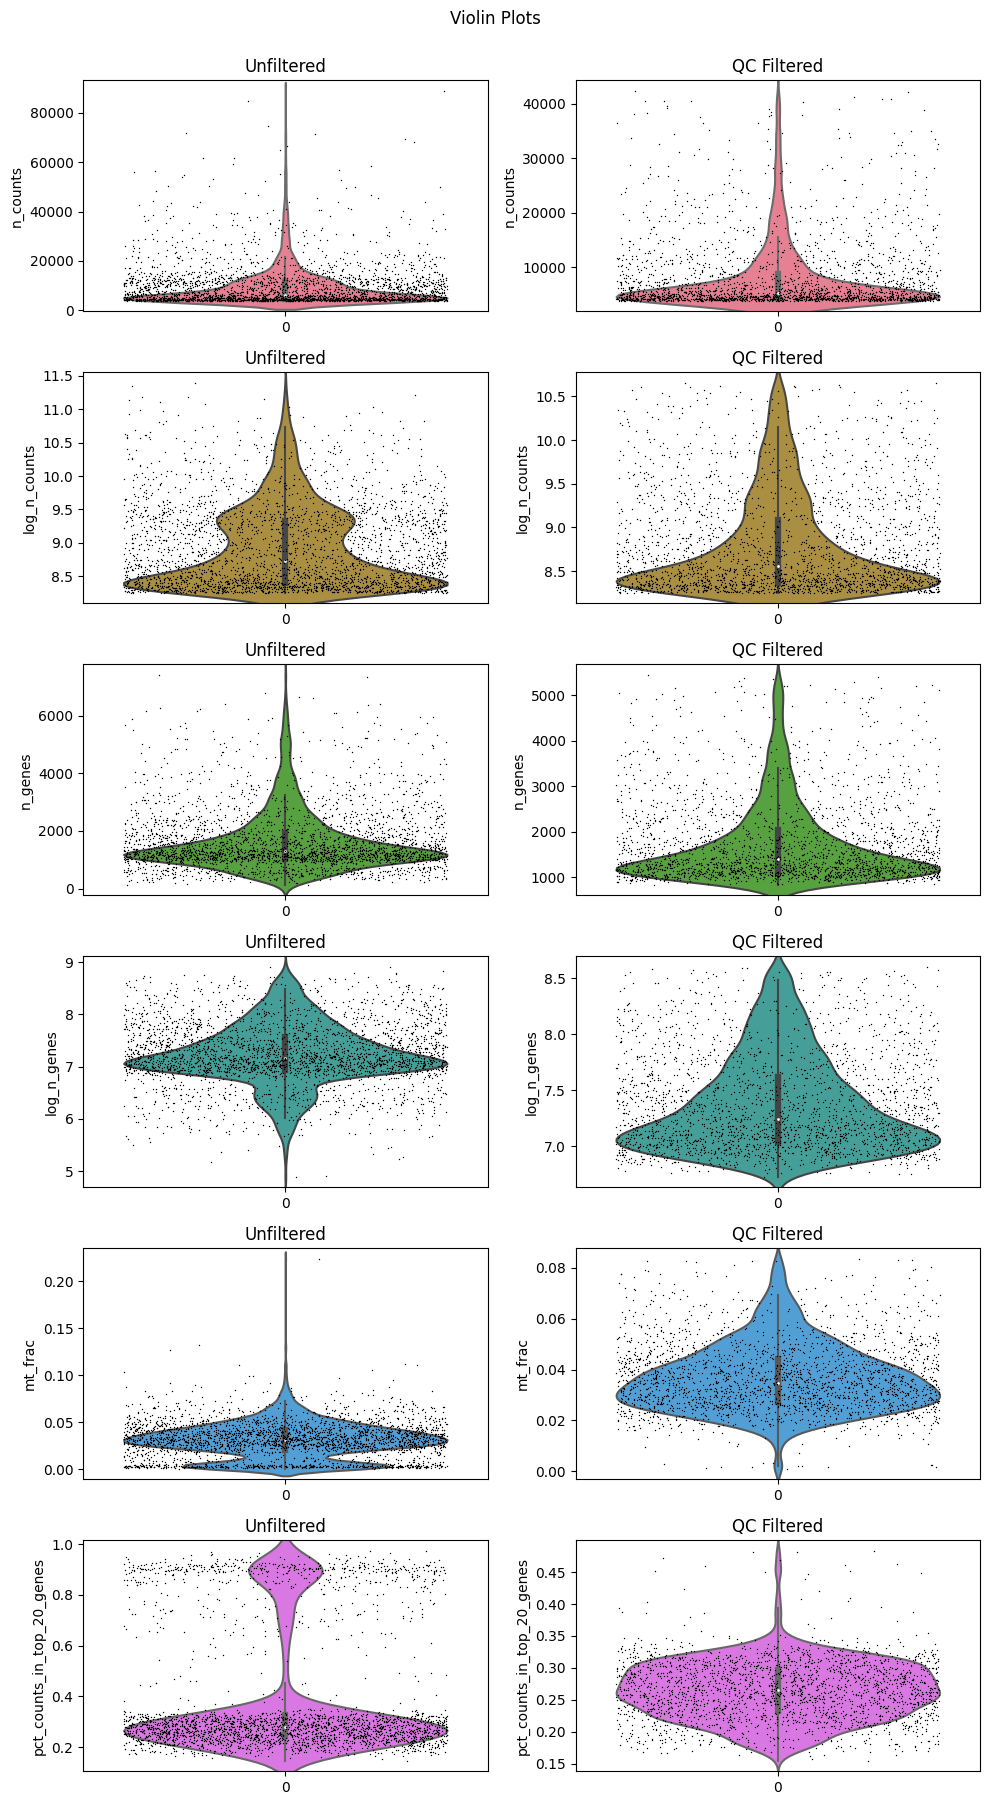

In [15]:
dp.EDA().ViolinJitter([adata, qc_adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered", "QC Filtered"])

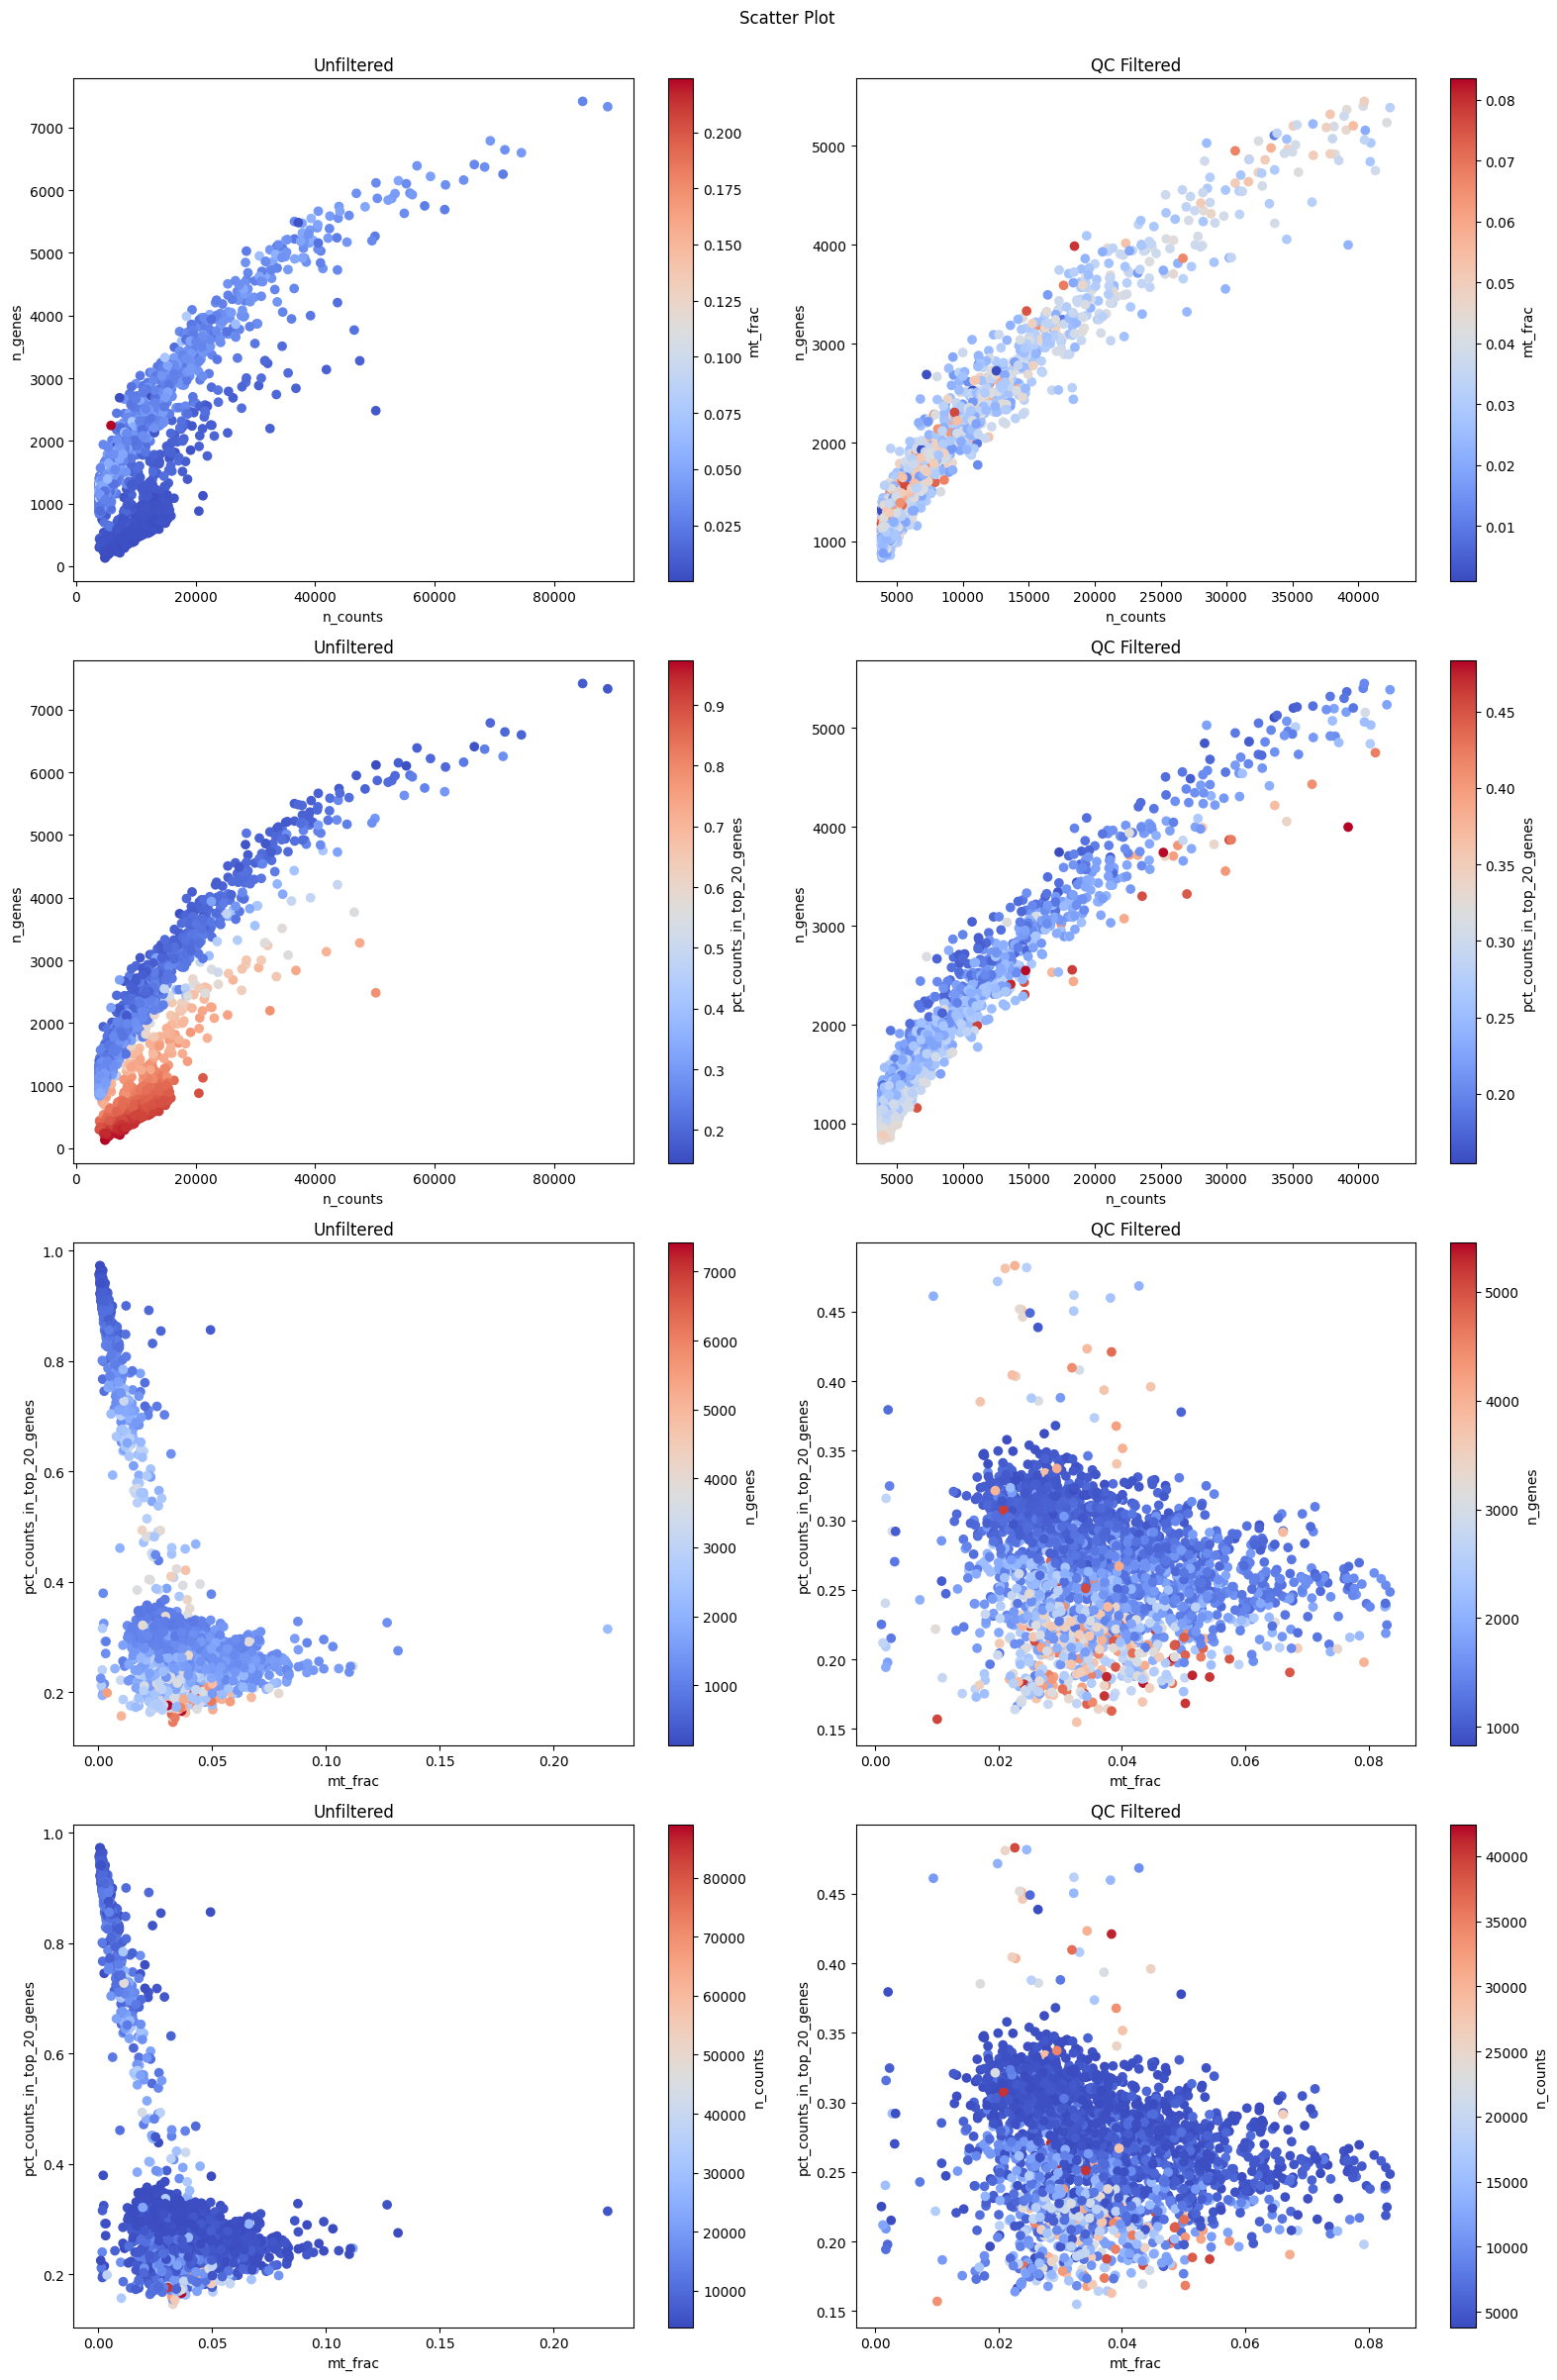

In [16]:
dp.EDA().ScatterForQCMetrics([adata, qc_adata],
                            title="Scatter Plot",
                            subtitle=["Unfiltered", "QC Filtered"])

## Normalize

In [17]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [18]:
norm_qc_adata

AnnData object with n_obs × n_vars = 2311 × 12438
    obs: 'tissue', 'age', 'treatment_protocol', 'method', 'instrument', 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'outlier', 'size_factors'
    var: 'gene_id', 'n_cells'
    layers: 'counts', 'log1p_counts'

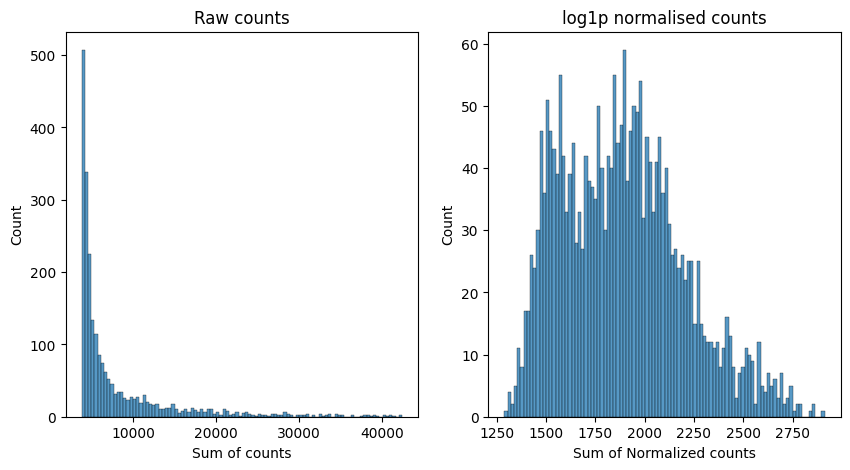

In [19]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [20]:
# Download normalized count matrix
normalized_counts = pd.DataFrame(norm_qc_adata.layers["log1p_counts"])
normalized_counts.index = norm_qc_adata.obs.index.to_list()
normalized_counts.columns = norm_qc_adata.var.index.to_list()
normalized_counts.to_csv("BM_1.csv")
norm_qc_adata.write("BM_1_adata.h5ad")